# precision > 0.7 이하인 클래스 삭제하고 분류 모델 제작
결막염, 비궤양성각막질환, 색소침착성각막염, 안검내반증, 안검염, 유루증

### 그래프 한글 안 깨지게 하는 코드

In [1]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

### 모듈 불러오기


In [ ]:
!pip install split-folders

In [3]:
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, AveragePooling2D, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # 모델 저장, 조기종료

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

import splitfolders


### 데이터 압축풀기

In [4]:
# !unzip -q "/content/drive/MyDrive/CV_project/data/안구질환/개_안구_squared_all.zip"

In [6]:
# import os

# base_dir = '/content/개_안구_squared_all'

# for root, dirs, files in os.walk(base_dir):
#     if root != base_dir:  # base_dir 자체는 제외
#         num_images = sum(1 for file in files if file.endswith('.jpg') or file.endswith('.png'))  # jpg, png 이미지 확인
#         print(f"{os.path.basename(root)}: {num_images} images")

궤양성각막질환: 15463 images
정상: 85139 images
안검염: 7731 images
안검내반증: 10789 images
결막염: 10799 images
비궤양성각막질환: 10797 images
안검종양: 5385 images
핵경화: 10798 images
색소침착성각막염: 7919 images
백내장: 23212 images
유루증: 10796 images


In [9]:
# import os
# import shutil

# # 삭제할 파일이 있는 디렉토리 경로
# base_path = "/content/개_안구_squared_all"

# # 삭제할 파일들의 이름 리스트
# files_to_delete = [
#     "결막염",
#     "비궤양성각막질환",
#     "색소침착성각막염",
#     "안검내반증",
#     "안검염",
#     "유루증",
#     "정상"
# ]

# # 파일 삭제
# for file_name in files_to_delete:
#     file_path = os.path.join(base_path, file_name)
#     if os.path.exists(file_path):
#         if os.path.isfile(file_path):
#             os.remove(file_path)
#             print(f"{file_name} 파일을 삭제했습니다.")
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#             print(f"{file_name} 디렉토리를 삭제했습니다.")
#     else:
#         print(f"{file_name} 파일이 존재하지 않습니다.")


결막염 파일이 존재하지 않습니다.
비궤양성각막질환 파일이 존재하지 않습니다.
색소침착성각막염 파일이 존재하지 않습니다.
안검내반증 파일이 존재하지 않습니다.
안검염 파일이 존재하지 않습니다.
유루증 파일이 존재하지 않습니다.
정상 디렉토리를 삭제했습니다.


In [12]:
# splitfolders.ratio('/content/개_안구_squared_all', output="개_안구_tr_te_va_squared_all_4class", ratio=(0.8, 0.1, 0.1))  # train/val/test = 8:1:1

Copying files: 54875 files [00:07, 7464.25 files/s]


In [ ]:
# prompt: /content/개_안구_tr_te_va_squared_all 이 파일을 압축파일로 드라이브에 저장하는 코드 알려줘

!zip -r /content/drive/MyDrive/개_안구_tr_te_va_squared_all_4class.zip /content/개_안구_tr_te_va_squared_all_4class


In [4]:
!unzip -q "/content/drive/MyDrive/개_안구_tr_te_va_squared_all_4class.zip"

In [5]:
import os

base_dir = '/content/개_안구_tr_te_va_squared_all_4class'

for root, dirs, files in os.walk(base_dir):
    if root != base_dir:  # base_dir 자체는 제외
        num_images = sum(1 for file in files if file.endswith('.jpg') or file.endswith('.png'))  # jpg, png 이미지 확인
        print(f"{os.path.basename(root)}: {num_images} images")


train: 0 images
궤양성각막질환: 12371 images
안검종양: 4307 images
핵경화: 8638 images
백내장: 18569 images
test: 0 images
궤양성각막질환: 1547 images
안검종양: 540 images
핵경화: 1081 images
백내장: 2322 images
val: 0 images
궤양성각막질환: 1545 images
안검종양: 538 images
핵경화: 1079 images
백내장: 2321 images


### 하이퍼파라미터 설정



In [15]:
batch_size = 64
img_size = 224
learning_rate = 5e-4
epochs = 40


classes_labels= [
    '궤양성각막질환',
    '백내장',
    '안검종양',
    '핵경화',
]

num_classes = len(classes_labels)
base_dir = '/content/개_안구_tr_te_va_squared_all_4class'

### 이미지 증강

In [16]:
# 이미지 증강이 적용된 데이터 제너레이터 선언
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,          # 이미지 픽셀 값을 0 ~ 1 사이로 정규화
    width_shift_range=0.1,     # 이미지를 가로로 10% 범위 내에서 무작위 이동
    height_shift_range=0.1,    # 이미지를 세로로 10% 범위 내에서 무작위 이동
    zoom_range=0.1,           # 이미지를 10% 범위 내에서 무작위 확대/축소
    horizontal_flip=True,      # 이미지를 좌우로 무작위 반전
)

validation_datagen = ImageDataGenerator(
    rescale=1. / 255,          # 검증 데이터에도 동일한 정규화 적용
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255          # 테스트 데이터에도 동일한 정규화 적용
)

# flow_from_directory: 디렉토리에서 이미지를 불러와 배치 단위로 제공
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),  # 훈련 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical',        # 다중 클래스 분류이므로 'categorical' 설정
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),    # 검증 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical',        # 다중 클래스 분류이므로 'categorical' 설정
    follow_links=True        # 숨김 파일 무시
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),   # 테스트 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical'         # 다중 클래스 분류이므로 'categorical' 설정
)


Found 43891 images belonging to 4 classes.
Found 5483 images belonging to 4 classes.
Found 5491 images belonging to 4 classes.


### 이미지 확인

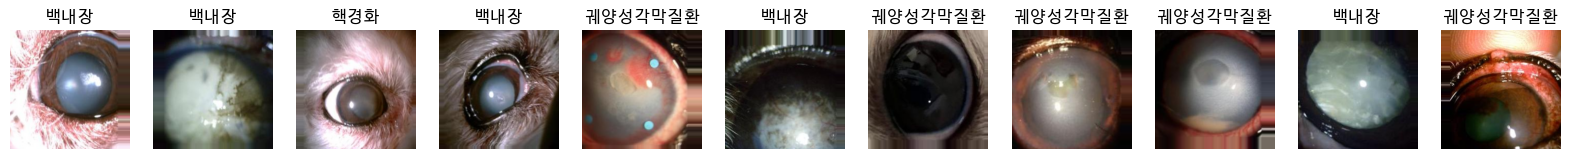

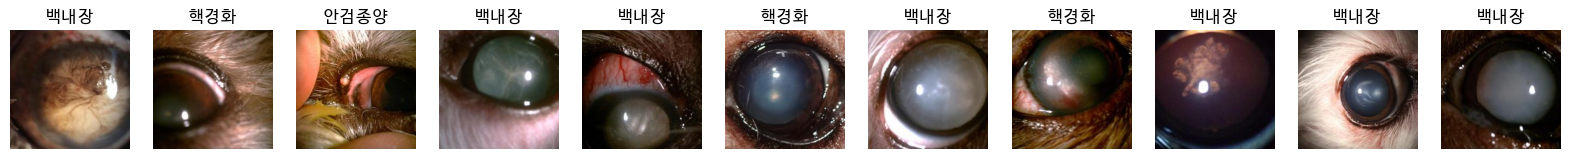

In [10]:
def show_images(generator, num_images=11):
    image, labels = next(generator)
    plt.figure(figsize=(20, 20))  # 이미지 개수에 따라 figsize 조절

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[i])

        # 클래스 레이블에 맞는 제목 설정
        class_index = np.argmax(labels[i])  # one-hot encoded labels에서 클래스 인덱스 추출

        # Check if class_index is within the range of classes_labels
        if class_index >= len(classes_labels):
            class_index = 0

        class_name = classes_labels[class_index]
        plt.title(class_name)

        plt.axis('off')
    plt.show()

show_images(train_generator, num_images=11)  # 모든 클래스 이미지 확인
show_images(test_generator, num_images=11)

## 모델 구현
* ResNet50v2 사용


In [11]:
# 모델 불러오기 및 선언
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(img_size, img_size, 3),  # 입력 이미지 크기 (224x224x3)
    include_top=False,                    # 사전 학습된 모델의 마지막 분류 레이어 제외
    weights='imagenet',                   # ImageNet 데이터셋으로 사전 학습된 가중치 사용
    pooling='avg'                         # 특징 맵을 평균 풀링하여 1차원 벡터로 변환
)

inputs = base_model.input                 # 입력 레이어 설정 (base_model의 입력 사용)
x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)  # 128개 노드의 은닉층 추가 (ReLU 활성화 함수 사용)
x = tf.keras.layers.Dropout(0.1)(x)       # 과적합 방지를 위한 드롭아웃 레이어 추가 (10% 드롭아웃)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)  # 출력 레이어 설정 (클래스 개수만큼 출력 노드, softmax 활성화 함수 사용)

# 모델 정의
model = tf.keras.Model(inputs=inputs, outputs=outputs)  # 입력과 출력을 연결하여 모델 생성

model.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                             

### 모델 컴파일링


In [17]:
# ophtimizer 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 콜백함수
callback = [ReduceLROnPlateau(monitor='val_loss', mode = 'min', factor=0.1, patience=4, min_lr=1e-7, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_squared_all_4class_b64_e40.tf', monitor='val_loss', mode='min', save_best_only=True)]
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True, mode="min", monitor='val_loss')  # 과대 적합 방지 및 , 필요하지 않은 훈련 하지 않도록 조기 종료

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)


## 모델 학습'


In [18]:
histroy = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[callback, early_stopping_cb]
)

Epoch 1/40
686/686 [==============================] - 540s 739ms/step - loss: 0.3393 - accuracy: 0.6752 - precision_2: 0.7183 - recall_2: 0.6214 - auc_2: 0.8921 - val_loss: 0.3504 - val_accuracy: 0.6677 - val_precision_2: 0.6876 - val_recall_2: 0.6520 - val_auc_2: 0.8891 - lr: 5.0000e-04
Epoch 2/40
686/686 [==============================] - 495s 721ms/step - loss: 0.3018 - accuracy: 0.7165 - precision_2: 0.7486 - recall_2: 0.6767 - auc_2: 0.9157 - val_loss: 0.3337 - val_accuracy: 0.6830 - val_precision_2: 0.7077 - val_recall_2: 0.6619 - val_auc_2: 0.8977 - lr: 5.0000e-04
Epoch 3/40
686/686 [==============================] - 495s 721ms/step - loss: 0.2830 - accuracy: 0.7345 - precision_2: 0.7625 - recall_2: 0.7034 - auc_2: 0.9264 - val_loss: 0.2888 - val_accuracy: 0.7301 - val_precision_2: 0.7560 - val_recall_2: 0.7071 - val_auc_2: 0.9229 - lr: 5.0000e-04
Epoch 4/40
686/686 [==============================] - 495s 721ms/step - loss: 0.2688 - accuracy: 0.7492 - precision_2: 0.7739 - recal

## 평가지표


In [1]:
# 학습 로그 출력
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(40), histroy.history['loss'], label='Train Loss', color="blue")
plt.plot(range(40), histroy.history['val_loss'], label='Validation Loss', color="red")
plt.title('Traning and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(40), histroy.history['accuracy'], label='Train Accuracy', color="blue")
plt.plot(range(40), histroy.history['val_accuracy'], label='Validation Accuracy', color="red")
plt.title('Traning and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# prompt: .h5 모델로 저장하는 코드 알려줘

model.save('/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_squared_all.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_squared_all_4class.tf')

trained_model.evaluate(test_generator)

172/172 [==============================] - 10s 54ms/step - loss: 0.2362 - accuracy: 0.7864 - precision: 0.7992 - recall: 0.7725 - auc: 0.9472


[0.23616932332515717,
 0.7863777279853821,
 0.7991710901260376,
 0.7725368738174438,
 0.9472035765647888]

In [ ]:
# prompt: /content/drive/MyDrive/CV_project/안구질환_모델/ 이 경로의 모델을 저장하는 코드 알려줘

model.save('/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_squared_e30_b32_model.tf')
